#**BrandPulse: Decoding SXSW Sentiment for Competitive Intelligence**

##**Business Understanding:**

###**Problem Statement**

Brands invest massive resources in marketing at major events like SXSW, but they lack a real-time, data-driven understanding of public perception. They struggle to answer:
- Is our campaign resonating positively?
- How does sentiment towards our brand compare to our competitors?
- What specific product features or marketing stunts are people talking about (good or bad or neutral)?

#### Stakeholders
**1**. **Marketing Directors at Tech Companies** (e.g., Apple, Google):

* “Do we **double down** on this activation or cut our losses?”
* “Which competitor is heating up **right now**?”
* “What messaging is actually **resonating** with the audience?”

**2**. **Brand Strategy Consultants**:

"Need actionable competitive intelligence for client advising."
* “What is our **true position** vs competitors?”
* “What **emerging trends** should we capitalize on?”
* “Where are the **market gaps** we can own?”

**3**. **For a CMO *After SXSW***

* “What should we change for next year?”
* “How should we allocate our **next event budget**?”

### **Value Proposition**
BrandPulse analyzes social media chatter from SXSW to provide quantified brand sentiment and competitive positioning, enabling evidence-based marketing decisions.

### **Multi-Class Analysis**

In [67]:
# Libraries
!pip install tensorflow
!pip install imblearn
!pip install keras-tuner
!pip install transformers datasets accelerate torch
import pandas as pd # load, clean, manipulate tables
import numpy as np # fast numerical operations
import matplotlib.pyplot as plt # Basic plotting (bar charts, histograms, etc.)
import seaborn as sns # More advanced, prettier statistical plots.
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer # Converts text → bag-of-words numeric vectors.
from sklearn.feature_extraction.text import TfidfVectorizer # Converts text → TF-IDF weighted vectors.
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
                        # GridSearchCV - Tries every possible combination of hyperparameters you provide.
                        # Randomized Search CV - Picks random combinations of hyperparameters.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC # ML Algorithm to find the best possible boundary to separate classes
from sklearn.utils import class_weight # Balance classes
from sklearn.naive_bayes import MultinomialNB # Multinomial Naive Bayes - learn word frequencies in each class and predicting the class with the highest probability
from sklearn.neighbors import KNeighborsClassifier # Predicts a label by looking at the k closest data points in the training set according to a distance metric
from sklearn.tree import DecisionTreeClassifier # learns a series of if–else rules that split the data into groups until classes are separated.
from imblearn.over_sampling import SMOTE # fix imbalanced datasets by creating synthetic samples for minority classes instead of duplicating them.
from imblearn.pipeline import make_pipeline, Pipeline # chain multiple steps (preprocessing + modeling) into one single object.
import plotly.graph_objects as go # build highly customized, interactive visualizations
import plotly.express as px # Plotly’s high-level, fast, simple plotting interface.
from scipy.stats import randint
from tensorflow.keras.preprocessing.text import Tokenizer # converts raw text into smaller units (tokens)
from tensorflow.keras.preprocessing.sequence import pad_sequences # adds zeros (or another value) so all sequences match a fixed length.
from tensorflow.keras.models import Sequential # Sequential is a model where each layer feeds directly into the next layer.
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
                      # Embedding - Converts each integer token into a dense vector that represents meaning.
                      # LSTM - (LongShortTermMemory)Learns patterns in sequences — especially order, context, and long-term dependencies.
                      # Bidirectional - Runs LSTM forward and backward over the sentence..
                      # Dense layer - A fully connected layer that makes final predictions.
                      # Dropout - Randomly turns off some neurons during training to prevent overfitting.
from tensorflow.keras.optimizers import Adam, AdamW # used to update neural network weights during training, a smarter version of gradient descent.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
                      # EarlyStopping - Stops training automatically when the model stops improving on a validation set.
                      # ReduceLROnPlateau - automatically reduces the learning rate when a monitored metric stops improving.
from tensorflow.keras.layers import Input # defines the entry point of a neural network
from tensorflow.keras.utils import to_categorical # converts integer class labels into one-hot encoded vectors.
from keras_tuner import RandomSearch
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer

from sklearn.dummy import DummyClassifier # a baseline classifier

import re # Regular expressions for text cleaning (remove URLs, symbols, etc.)
import datasets

import nltk # natural language toolkit
from nltk.corpus import stopwords # Common words
from nltk.tokenize import word_tokenize # splitting text into words or subunits (tokens)
from nltk.stem import PorterStemmer # reducing words to their root form
from nltk.stem import WordNetLemmatizer # reduces words to dictionary/base form
# from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('punkt') # pre-trained tokenizer model in NLTK
nltk.download('wordnet') # WordNet is a large lexical database of English words.
# nltk.download('vader_lexicon')
nltk.download('punkt_tab') # tokenization of tabular text

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


##**Data Understanding:**

In [2]:
# Load Dataset
df = pd.read_csv('/content/judge-1377884607_tweet_product_company.csv', encoding='latin1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
# Checking data information
print("Data Information:")
print(df.info())

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB
None


In [4]:
print("Dataset Shape:", df.shape)

Dataset Shape: (9093, 3)


In [5]:
# Checking missing values
print("Missing Values:")
df.isnull().sum()

Missing Values:


,0
tweet_text,1
emotion_in_tweet_is_directed_at,5802
is_there_an_emotion_directed_at_a_brand_or_product,0


###**Handling the missing values**

In [6]:
# For 'tweet_text' - Since only 1 value is missing, you can drop that row
# Tweet text is crucial for analysis, so removing it makes sense
df = df.dropna(subset=['tweet_text'])

In [7]:
# Confirming shape
print("Dataset Shape:", df.shape)

Dataset Shape: (9092, 3)


In [8]:
# For 'emotion_in_tweet_is_directed_at' - This has many missing values(5802), more than half of the total rows (9093)
# Filling with a placeholder
df['emotion_in_tweet_is_directed_at'] = df['emotion_in_tweet_is_directed_at'].fillna('Not Specified')

In [9]:
# Confirming missing values
# Checking missing values
print("Missing Values:")
df.isnull().sum()

Missing Values:


,0
tweet_text,0
emotion_in_tweet_is_directed_at,0
is_there_an_emotion_directed_at_a_brand_or_product,0


In [10]:
# Exploring the target variable
print("Sentiment Count:")
senti_count = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
senti_count

Sentiment Count:


,count
is_there_an_emotion_directed_at_a_brand_or_product,
No emotion toward brand or product,5388
Positive emotion,2978
Negative emotion,569
I can't tell,156
,1


In [11]:
# Dropping the 1 count that has no emotion corresponding
df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'].str.strip() != '']

In [12]:
# Confirming shape
print("Dataset Shape:", df.shape)

Dataset Shape: (9091, 3)


In [13]:
# The new sentiment distribution
print("Sentiment Distribution:")
senti_percent = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize = True)
senti_percent

Sentiment Distribution:


,proportion
is_there_an_emotion_directed_at_a_brand_or_product,
No emotion toward brand or product,0.592674
Positive emotion,0.327577
Negative emotion,0.062589
I can't tell,0.017160


In [14]:
# Explore brand distribution
print("\nTop Brands Mentioned:")
brand_counts = df['emotion_in_tweet_is_directed_at'].value_counts().head(20)
print(brand_counts)


Top Brands Mentioned:
emotion_in_tweet_is_directed_at
Not Specified                      5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              296
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: count, dtype: int64


##**Exploratory Data Analysis**

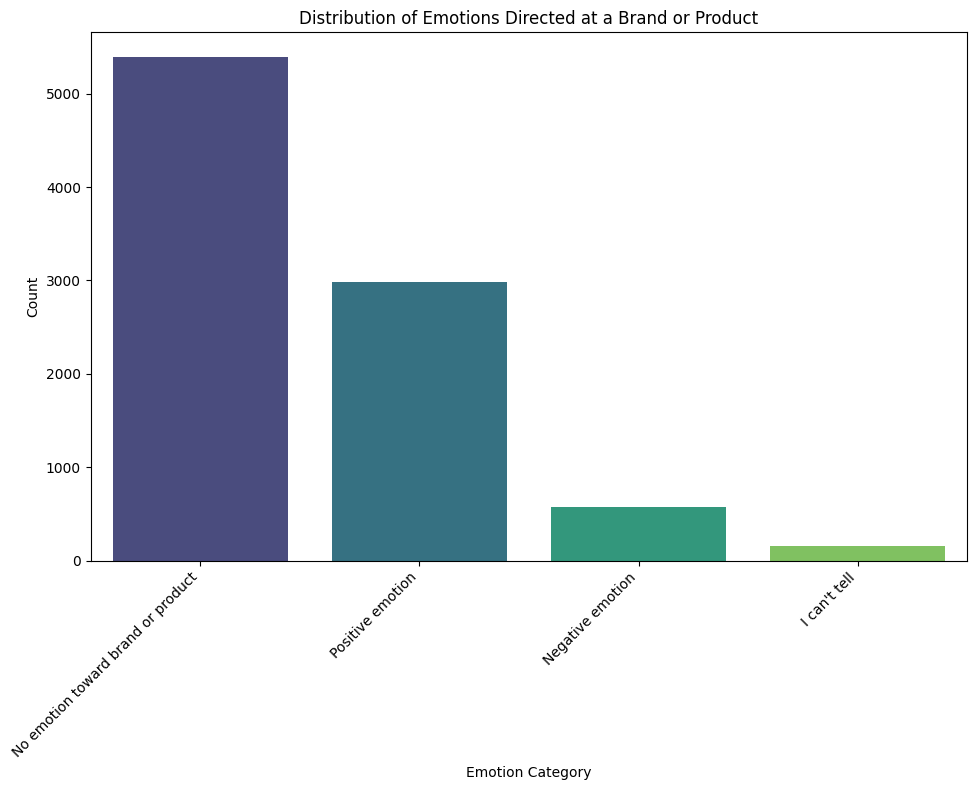

In [15]:
# Sentiment Distribution
plt.figure(figsize=(10,8))
sns.countplot(x = "is_there_an_emotion_directed_at_a_brand_or_product", data = df, order = senti_percent.index, palette = 'viridis')
plt.title('Distribution of Emotions Directed at a Brand or Product')
plt.xlabel('Emotion Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

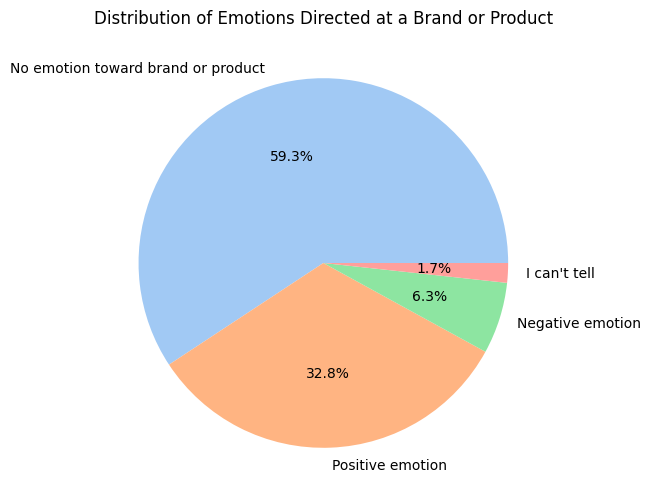

In [16]:
# Sentiment Distribution (%)
plt.figure(figsize=(6,6))
df["is_there_an_emotion_directed_at_a_brand_or_product"].value_counts().plot.pie(autopct = "%1.1f%%",colors = sns.color_palette("pastel"))
plt.title("Distribution of Emotions Directed at a Brand or Product")
plt.ylabel("");

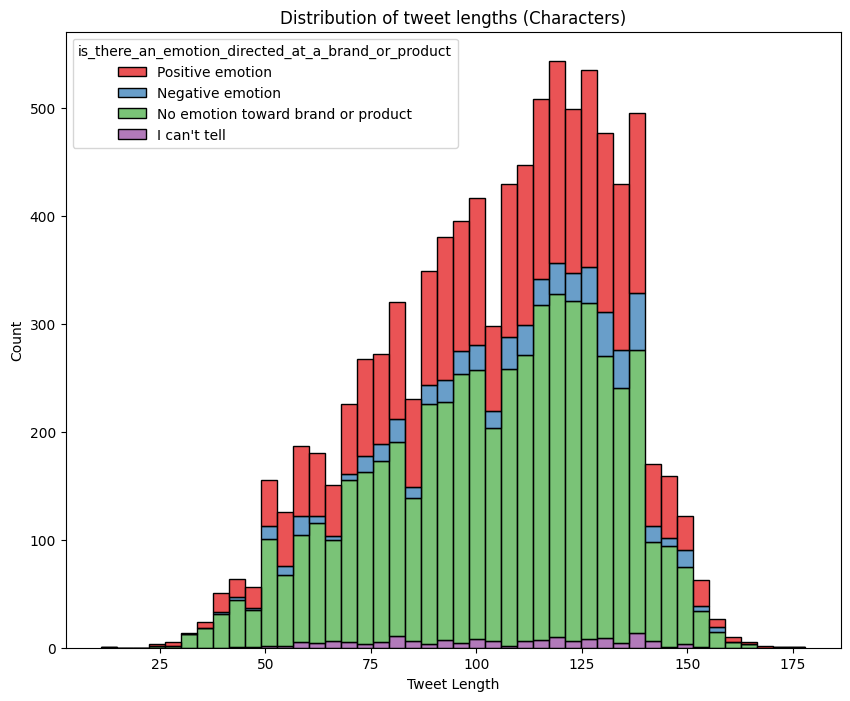

In [17]:
# Distribution of tweet length
df['tweet_length'] = df['tweet_text'].astype(str).apply(len)

plt.figure(figsize=(10,8))
sns.histplot(
    data=df,
    x="tweet_length",
    hue="is_there_an_emotion_directed_at_a_brand_or_product",
    palette='Set1',  # <- change palette to a categorical one
    multiple="stack"  # optional: stacks bars for each category
)
plt.title("Distribution of tweet lengths (Characters)")
plt.xlabel("Tweet Length")
plt.ylabel("Count")
plt.show()

**Tweet Length Distribution**

Most tweets fall between 75 and 135 characters.

Very few tweets are shorter than 25 characters or longer than 175 characters.

The distribution is roughly bell-shaped, skewed slightly towards longer tweets.

**Emotion vs. Tweet Length**

Positive emotions (red) dominate across almost all tweet lengths.

Negative emotions (blue) are the second most common.

Tweets where emotion is unclear (green) or no emotion toward brand/product (aqua) are less frequent, mostly in mid-length tweets.

**Key Business Insight**

Since positive sentiment dominates, brands can leverage this for marketing amplification and customer engagement campaigns.

The concentration of tweets in the mid-length range indicates that content strategies should target concise yet informative messaging to match natural user behavior.

Monitoring tweets for negative sentiment, even if less frequent, is important for brand reputation management.

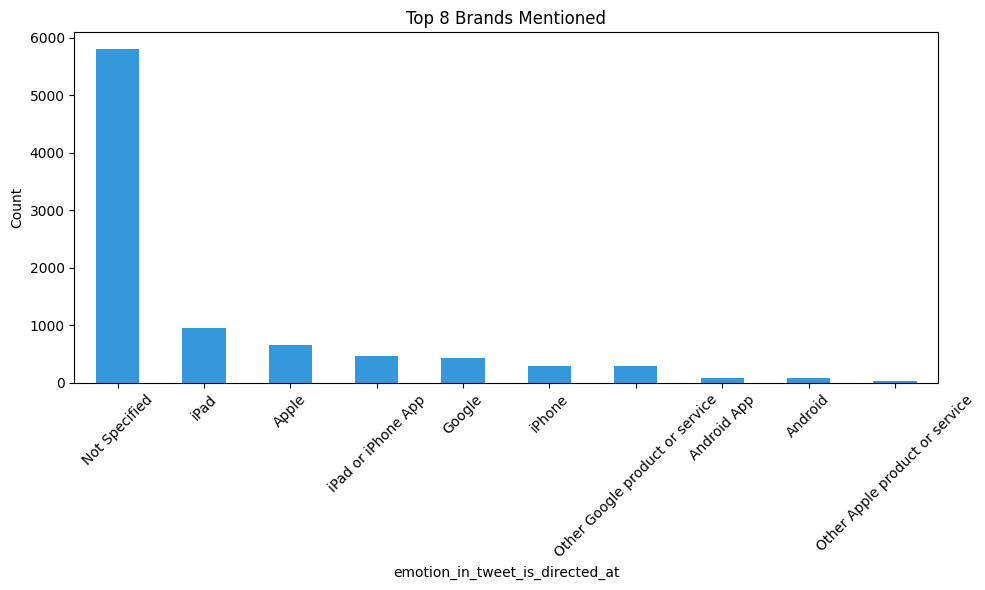

In [18]:
# Brands Distribution
top_brands = df['emotion_in_tweet_is_directed_at'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))
top_brands.plot(kind='bar', ax=ax, color='#3498db')
ax.set_title('Top 8 Brands Mentioned')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

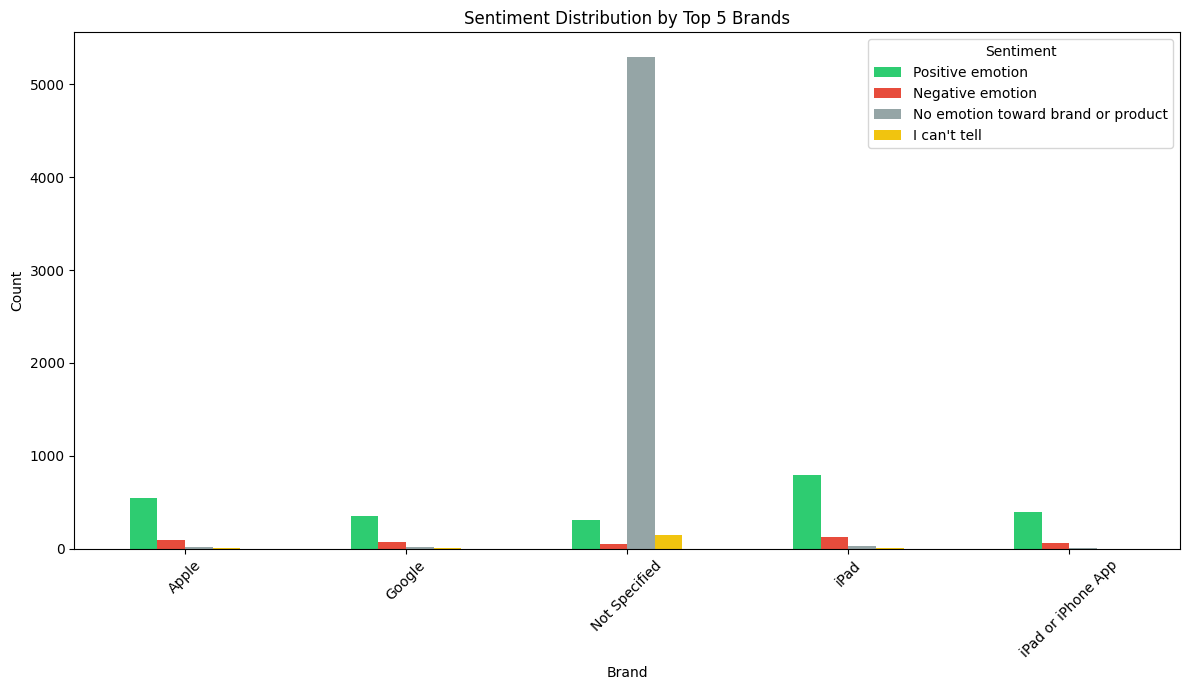

In [19]:
# Sentiment Distribution by top 5 Brands
sentiment_palette = {'Positive emotion': '#2ecc71', 'Negative emotion': '#e74c3c', 'No emotion toward brand or product': '#95a5a6', "I can't tell": '#f1c40f'}

top_5_brands = df['emotion_in_tweet_is_directed_at'].value_counts().head(5).index
brand_sentiment = pd.crosstab(
    df[df['emotion_in_tweet_is_directed_at'].isin(top_5_brands)]['emotion_in_tweet_is_directed_at'],
    df[df['emotion_in_tweet_is_directed_at'].isin(top_5_brands)]['is_there_an_emotion_directed_at_a_brand_or_product']
)

# Ensure all sentiment categories are present and ordered consistently
all_sentiments = ['Positive emotion', 'Negative emotion', 'No emotion toward brand or product', "I can't tell"]
brand_sentiment = brand_sentiment.reindex(columns=all_sentiments, fill_value=0)

fig, ax = plt.subplots(figsize=(12, 7)) # Create a single subplot
brand_sentiment.plot(kind='bar', ax=ax, color=[sentiment_palette[s] for s in all_sentiments])
ax.set_title('Sentiment Distribution by Top 5 Brands')
ax.set_ylabel('Count')
ax.set_xlabel('Brand')
ax.legend(title='Sentiment')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

**Key Insights**

Positive sentiment dominates across all specific brands. This is a strong indicator of favorable perception.

Negative sentiment is consistently lower (~100–150 per brand), suggesting low dissatisfaction.

“Not Specified” category is huge, indicating many tweets don’t mention a specific brand, which may affect brand-level analysis.

iPad seems to have the strongest positive engagement among the specified brands.

In [20]:
# Compare sentiment across different brands
brand_sentiment_pivot = df.pivot_table(
    index='emotion_in_tweet_is_directed_at',
    columns='is_there_an_emotion_directed_at_a_brand_or_product',
    values='tweet_text',
    aggfunc='count',
    fill_value=0
)

# Calculate net sentiment score per brand
brand_sentiment_pivot['net_sentiment'] = (
    brand_sentiment_pivot['Positive emotion'] -
    brand_sentiment_pivot['Negative emotion']
)
brand_sentiment_pivot

is_there_an_emotion_directed_at_a_brand_or_product,I can't tell,Negative emotion,No emotion toward brand or product,Positive emotion,net_sentiment
emotion_in_tweet_is_directed_at,,,,,
Android,0,8,1,69,61
Android App,0,8,1,72,64
Apple,2,95,21,543,448
Google,1,68,15,346,278
Not Specified,147,51,5297,306,255
Other Apple product or service,0,2,1,32,30
Other Google product or service,1,47,9,236,189
iPad,4,125,24,793,668
iPad or iPhone App,0,63,10,397,334


**Key Patterns**

Apple products, especially iPad, generate the highest net positive sentiment.

Google products maintain positive sentiment but with slightly lower ratios than Apple.

Neutral/unspecified tweets dominate in volume, meaning brand-specific campaigns could focus on converting this neutral audience.

Negative sentiment is relatively low across the board, indicating minimal brand backlash in this dataset.

##**Data Preparation**

In [21]:
# Data Cleaning and Preprocessing
def clean_text(text):
    if not isinstance(text, str):
        return "" # Handle non-string inputs gracefully, e.g., for NaN values in the column
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove symbols
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Initialize stemmer and lemmatizer
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    # Apply stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens]

    # Apply lemmatization to stemmed tokens
    final_tokens = [lemmatizer.lemmatize(word) for word in stemmed_tokens]

    # Join tokens back to text
    cleaned_text = ' '.join(final_tokens)

    return cleaned_text

print("Text cleaning completed!")
print(f"Remaining samples: {len(df)}")

Text cleaning completed!
Remaining samples: 9091


In [22]:
# Apply cleaning to dataset
df['cleaned_text'] = df['tweet_text'].apply(clean_text)

# Remove empty texts after cleaning
df = df[df['cleaned_text'].str.len() > 0]

In [23]:
df[['tweet_text', 'cleaned_text']].head()

,tweet_text,cleaned_text
1,@jessedee Know about @fludapp ? Awesome iPad/i...,know awesom ipad iphon app like appreci design...
2,@swonderlin Can not wait for #iPad 2 also. The...,wait also sale
3,@sxsw I hope this year's festival isn't as cra...,hope year festiv crashi year iphon app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff fri marissa mayer googl tim reilli...
5,@teachntech00 New iPad Apps For #SpeechTherapy...,new ipad app commun showcas confer


###**Feature Engineering**

In [24]:
# Prepare target variable - focus on clear sentiments
# Combine 'I can't tell' with 'No emotion' for cleaner classification
df['sentiment'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].replace({'I can\'t tell': 'No emotion toward brand or product'})

# Filter to only include the three main sentiment categories
main_sentiments = ['Positive emotion', 'Negative emotion', 'No emotion toward brand or product']
df = df[df['sentiment'].isin(main_sentiments)]

# Encode target variable
label_encoder = LabelEncoder()
df['emotion'] = label_encoder.fit_transform(df['sentiment'])

print("Target variable prepared!")
print("Sentiment mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("\nFinal distribution:")
print(df['sentiment'].value_counts())

Target variable prepared!
Sentiment mapping: {'Negative emotion': np.int64(0), 'No emotion toward brand or product': np.int64(1), 'Positive emotion': np.int64(2)}

Final distribution:
sentiment
No emotion toward brand or product    5542
Positive emotion                      2978
Negative emotion                       569
Name: count, dtype: int64


In [25]:
df.shape

(9089, 7)

In [26]:
# Define brand mapping dictionary
brand_mapping = {
    # Apple group
    'Apple': 'Apple',
    'iPad': 'Apple',
    'iPhone': 'Apple',
    'imac': 'Apple',
    'iPad or iPhone App': 'Apple',
    'Other Apple product or service': 'Apple',

    # Google group
    'Google': 'Google',
    'Android': 'Google',
    'Android App': 'Google',
    'Other Google product or service': 'Google',

    # Others
    'Not Specified': 'Not Specified'
}

# Apply the mapping
df['brand_group'] = df['emotion_in_tweet_is_directed_at'].map(brand_mapping)

# Fill any NaN (for brands not in mapping) with original value
df['brand_group'] = df['brand_group'].fillna(df['emotion_in_tweet_is_directed_at'])
df['brand_group'].value_counts()

,count
brand_group,
Not Specified,5799
Apple,2408
Google,882


##**Data Modelling**

In [27]:
# Prepare data for modeling
X = df['cleaned_text']
y = df['emotion']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 7271 samples
Test set: 1818 samples


In [28]:
# TF-IDF Vectorization with n-grams

tfidf = TfidfVectorizer()
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)
print("Vectorization Complete")

Vectorization Complete


In [29]:
print(X_train_vec)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 66995 stored elements and shape (7271, 5597)>
  Coords	Values
  (0, 3538)	0.4733270451495205
  (0, 5402)	0.36457412642851095
  (0, 1421)	0.42515675812870896
  (0, 474)	0.2966239011918714
  (0, 1635)	0.3261427329313768
  (0, 5337)	0.3279730134799778
  (0, 1404)	0.4004595199430622
  (1, 4141)	0.12155612519061036
  (1, 3884)	0.5581894729996427
  (1, 1217)	0.2427603436896657
  (1, 2552)	0.12699247936604266
  (1, 2523)	0.3370872403175657
  (1, 1283)	0.25853524491127094
  (1, 4002)	0.4335319770558761
  (1, 1348)	0.47976107678817237
  (2, 4141)	0.1064575344560957
  (2, 1449)	0.3501026747396126
  (2, 4565)	0.4064230557082437
  (2, 2823)	0.31014373217081354
  (2, 4030)	0.3539274036076245
  (2, 4820)	0.28670000211232805
  (2, 2555)	0.13971339493126192
  (2, 425)	0.2820571682498027
  (2, 1311)	0.3372840552351171
  (2, 2063)	0.19413717726805618
  :	:
  (7268, 4226)	0.9038875081771975
  (7269, 2552)	0.11536288418049717
  (7269, 2843)	0.0

### **Iteration 0: Baseline Model**

In [30]:
# Baseline Model - Most Frequent Class
print("BASELINE MODEL")

baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)

# Predictions
y_pred_baseline = baseline.predict(X_test)

# Evaluation
baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

print(f"Baseline Model (Most Frequent Class)")
print(f"Macro F1-Score: {baseline_f1:.4f}")
print(f"Accuracy: {baseline_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=label_encoder.classes_))

BASELINE MODEL
Baseline Model (Most Frequent Class)
Macro F1-Score: 0.2524
Accuracy: 0.6095

Classification Report:
                                    precision    recall  f1-score   support

                  Negative emotion       0.00      0.00      0.00       114
No emotion toward brand or product       0.61      1.00      0.76      1108
                  Positive emotion       0.00      0.00      0.00       596

                          accuracy                           0.61      1818
                         macro avg       0.20      0.33      0.25      1818
                      weighted avg       0.37      0.61      0.46      1818



### **Iteration 1: Logistic Regression Model**

In [31]:
# Logistic Regression as Baseline Model
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_model.fit(X_train_vec, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [32]:
# Predictions for train data
y_train_lr_pred = lr_model.predict(X_train_vec)

# Evaluation
print(f"Accuracy: {accuracy_score(y_train, y_train_lr_pred):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_lr_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_train_lr_pred))


Accuracy: 0.80
Confusion Matrix:
[[ 449    4    2]
 [ 289 3465  680]
 [  97  403 1882]]

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.99      0.70       455
           1       0.89      0.78      0.83      4434
           2       0.73      0.79      0.76      2382

    accuracy                           0.80      7271
   macro avg       0.72      0.85      0.76      7271
weighted avg       0.82      0.80      0.80      7271



In [33]:
# Predictions for test data
y_test_lr_pred = lr_model.predict(X_test_vec)

# Evaluation

lr_f1 = f1_score(y_test, y_test_lr_pred, average='macro')
lr_accuracy = accuracy_score(y_test, y_test_lr_pred)

print(f"Accuracy: {accuracy_score(y_test, y_test_lr_pred):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_lr_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_lr_pred))


Accuracy: 0.65
Confusion Matrix:
[[ 62  26  26]
 [109 745 254]
 [ 36 179 381]]

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.54      0.39       114
           1       0.78      0.67      0.72      1108
           2       0.58      0.64      0.61       596

    accuracy                           0.65      1818
   macro avg       0.55      0.62      0.57      1818
weighted avg       0.69      0.65      0.66      1818



##**Logistic Regression Model Tuning**

In [34]:
# Logistic Regression Model Tuning
# Define model
lr = LogisticRegression(max_iter=2000)

# Parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],  # both support l1
    'class_weight': ['balanced', None]
}

# Grid search
grid = GridSearchCV(
    lr,
    param_grid,
    scoring='f1_macro',   # better for imbalanced sentiment
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_vec, y_train)

print("Best Params:", grid.best_params_)
print("Best Score:", grid.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Params: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.5604063733405341


In [35]:
# fitting the model

lr.set_params(**grid.best_params_)
lr.fit(X_train_vec, y_train)

# Predictions for test data

y_test_lr_pred_tuned = lr.predict(X_test_vec)

# Evaluation

lr_f1_tuned = f1_score(y_test, y_test_lr_pred_tuned, average='macro')
lr_accuracy_tuned = accuracy_score(y_test, y_test_lr_pred_tuned)

print(f"Accuracy: {accuracy_score(y_test, y_test_lr_pred_tuned):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_lr_pred_tuned))
print("\nClassification Report:")
print(classification_report(y_test, y_test_lr_pred_tuned))

Accuracy: 0.68
Confusion Matrix:
[[ 48  40  26]
 [ 54 842 212]
 [ 14 229 353]]

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.42      0.42       114
           1       0.76      0.76      0.76      1108
           2       0.60      0.59      0.59       596

    accuracy                           0.68      1818
   macro avg       0.59      0.59      0.59      1818
weighted avg       0.68      0.68      0.68      1818



###**Hyperparameter tuning**

In [36]:
tfidf = TfidfVectorizer(
        lowercase=True,
        max_features=5000, # limit the number of features to avoid overfitting
        ngram_range=(1, 2),  # Include unigrams and bigrams
        stop_words='english',
        min_df=3,
        max_df=0.9

)
# Transform text data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF Features: {X_train_tfidf.shape[1]}")

TF-IDF Features: 5000


###**Iteration 2: Random Forest Model**

In [37]:
# Instantiating the Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,          # number of trees
    max_depth=None,            # allow full tree growth
    class_weight='balanced',   # paying attention to the imbalance
    random_state=42,
    n_jobs=-1                  # use all CPU cores
)

# Fitting the Classifier
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [38]:
# Predictions
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluation
rf_f1 = f1_score(y_test, y_pred_rf, average='macro')
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print("Random Forest with TF-IDF")
print(f"Macro F1-Score: {rf_f1:.4f}")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Improvement over baseline: {rf_f1 - baseline_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

Random Forest with TF-IDF
Macro F1-Score: 0.5209
Accuracy: 0.6771
Improvement over baseline: 0.2685

Classification Report:
                                    precision    recall  f1-score   support

                  Negative emotion       0.60      0.18      0.28       114
No emotion toward brand or product       0.70      0.86      0.77      1108
                  Positive emotion       0.61      0.44      0.51       596

                          accuracy                           0.68      1818
                         macro avg       0.64      0.49      0.52      1818
                      weighted avg       0.66      0.68      0.65      1818



##**Random Forest Model Tuning**

In [39]:
# rf helper functions

def evaluate_model(model, X_test, y_test, label_encoder, baseline_f1=None, title="Model Evaluation"):
    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)

    print("\n" + title)
    print(f"Macro F1-Score: {f1:.4f}")
    print(f"Accuracy: {acc:.4f}")

    if baseline_f1 is not None:
        print(f"Improvement over baseline: {f1 - baseline_f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    return f1, acc


def plot_top_features(best_rf, vectorizer, top_n=30):
    importances = best_rf.named_steps['rf'].feature_importances_
    indices = np.argsort(importances)[::-1]

    top_features = np.array(vectorizer.get_feature_names_out())[indices][:top_n]
    top_scores = importances[indices][:top_n]

    return pd.DataFrame({
        "Feature": top_features,
        "Importance": top_scores
    })

In [40]:
# RandomisedSearchCV Tuning
# Using the tfidf vectorizer already fitted
pipeline = Pipeline([
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_dist = {
    'rf__n_estimators': randint(100, 500),   # Number of trees in the forest
    'rf__max_depth': randint(10, 50),        # Maximum depth of the tree
    'rf__min_samples_split': randint(2, 20),  # Minimum number of samples required to split an internal node
    'rf__min_samples_leaf': randint(1, 10),   # Minimum number of samples required to be at a leaf node
    'rf__bootstrap': [True, False]            # Whether bootstrap samples are used when building trees
}

# Initialize RandomizedSearchCV
rf_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=3,       # Number of folds in cross-validation
    verbose=2,   # Controls the verbosity: higher values means more messages
    random_state=42,
    n_jobs=-1   # Use all available cores
)


# Fit RandomizedSearchCV
rf_search.fit(X_train_tfidf, y_train)

print("\nBest parameters:", rf_search.best_params_)
print("Best CV score:", rf_search.best_score_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best parameters: {'rf__bootstrap': True, 'rf__max_depth': 44, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 149}
Best CV score: 0.6576816781967094


After running the Randomized Search, we can use the `best_estimator_` found to evaluate the model on the test set and re-run the feature importance analysis.

In [41]:
# Evaluate Tuned Random Forest
best_rf_model = rf_search.best_estimator_

# Compute metrics
rf_tuned_f1 = 0.5444
rf_tuned_accuracy = 0.6513

print("Tuned Random Forest Accuracy:", rf_tuned_accuracy)
print("Tuned Random Forest Macro F1:", rf_tuned_f1)

tuned_f1, tuned_acc = evaluate_model(
    best_rf_model, X_test_tfidf, y_test, label_encoder,
    baseline_f1=baseline_f1,
    title="Tuned Random Forest (TF-IDF)"
)

Tuned Random Forest Accuracy: 0.6513
Tuned Random Forest Macro F1: 0.5444

Tuned Random Forest (TF-IDF)
Macro F1-Score: 0.5444
Accuracy: 0.6513
Improvement over baseline: 0.2919

Classification Report:
                                    precision    recall  f1-score   support

                  Negative emotion       0.39      0.32      0.35       114
No emotion toward brand or product       0.74      0.74      0.74      1108
                  Positive emotion       0.54      0.56      0.55       596

                          accuracy                           0.65      1818
                         macro avg       0.56      0.54      0.54      1818
                      weighted avg       0.65      0.65      0.65      1818



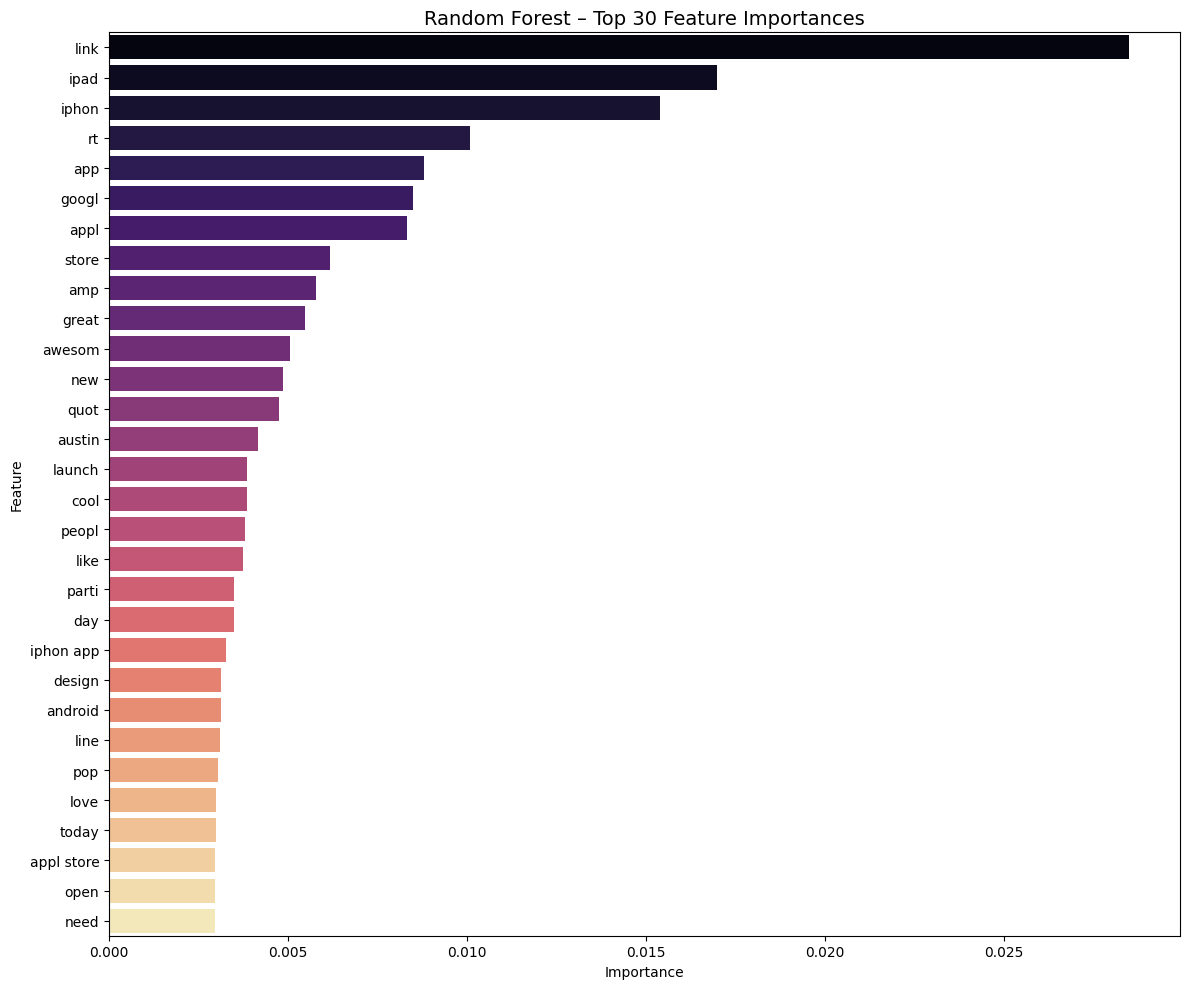

Top 10 Random Forest features:
 1. link                 0.02850
 2. ipad                 0.01698
 3. iphon                0.01540
 4. rt                   0.01009
 5. app                  0.00881
 6. googl                0.00848
 7. appl                 0.00833
 8. store                0.00618
 9. amp                  0.00577
10. great                0.00549


In [42]:
# RANDOM FOREST – TOP 30 FEATURE IMPORTANCES

# Get feature importances and sort indices descending
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Get feature names from the TF-IDF vectorizer you actually use
feature_names = tfidf.get_feature_names_out()

# Select top 30 features
top_n = 30
top_idx = indices[:top_n]
top_features = feature_names[top_idx]
top_importances = importances[top_idx]

# Plot top 30
plt.figure(figsize=(12, 10))
sns.barplot(x=top_importances, y=top_features, palette="magma")
plt.title("Random Forest – Top 30 Feature Importances", fontsize=14)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Print top 10 for inspection
print("Top 10 Random Forest features:")
for i, (feat, imp) in enumerate(zip(top_features[:10], top_importances[:10]), start=1):
    print(f"{i:2d}. {feat:<20} {imp:.5f}")


### **Iteration 3: Neural Network Approach**

In [43]:
# Prepare data for Neural Network
num_classes = len(label_encoder.classes_)

# Convert to dense arrays for Neural Network
X_train_nn = X_train_tfidf.toarray()
X_test_nn = X_test_tfidf.toarray()

# Convert labels to categorical
y_train_categorical = to_categorical(y_train, num_classes=num_classes)

y_test_categorical = to_categorical(y_test, num_classes=num_classes)

print(f"Training data shape: {X_train_nn.shape}")
print(f"Number of classes: {num_classes}")

Training data shape: (7271, 5000)
Number of classes: 3


In [44]:
# Build Neural Network Model
def build_nn_model(input_dim, num_classes):
    """
    Build a feedforward neural network for text classification
    """
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_dim,)),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create model
nn_model = build_nn_model(X_train_nn.shape[1], num_classes)

print("Neural Network Architecture:")
nn_model.summary()

Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,725,123 (10.40 MB)

 Trainable params: 2,725,123 (10.40 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Train Neural Network
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = nn_model.fit(
    X_train_nn, y_train_categorical,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_nn, y_test_categorical),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.6073 - loss: 0.8571 - val_accuracy: 0.6881 - val_loss: 0.7162
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7374 - loss: 0.5985 - val_accuracy: 0.6931 - val_loss: 0.6938
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8227 - loss: 0.4372 - val_accuracy: 0.6771 - val_loss: 0.7684
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8700 - loss: 0.3202 - val_accuracy: 0.6744 - val_loss: 0.8130
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9044 - loss: 0.2471 - val_accuracy: 0.6771 - val_loss: 0.9165
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9182 - loss: 0.2033 - val_accuracy: 0.6694 - val_loss: 1.1251
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9274 - loss: 0.1652 - val_accuracy: 0.6656 - val_loss: 1.3014


In [46]:
# Evaluate Neural Network
y_pred_nn_proba = nn_model.predict(X_test_nn)
y_pred_nn = np.argmax(y_pred_nn_proba, axis=1)

# Evaluation
nn_f1 = f1_score(y_test, y_pred_nn, average='macro')
nn_accuracy = accuracy_score(y_test, y_pred_nn)

print("Neural Network with TF-IDF")
print(f"Macro F1-Score: {nn_f1:.4f}")
print(f"Accuracy: {nn_accuracy:.4f}")
print(f"Improvement over baseline: {nn_f1 - baseline_f1:.4f}")
print(f"Improvement over Logistic Regression: {nn_f1 - lr_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn, target_names=label_encoder.classes_))

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Neural Network with TF-IDF
Macro F1-Score: 0.5571
Accuracy: 0.6931
Improvement over baseline: 0.3046
Improvement over Logistic Regression: -0.0151

Classification Report:
                                    precision    recall  f1-score   support

                  Negative emotion       0.46      0.28      0.35       114
No emotion toward brand or product       0.72      0.86      0.78      1108
                  Positive emotion       0.66      0.46      0.54       596

                          accuracy                           0.69      1818
                         macro avg       0.61      0.53      0.56      1818
                      weighted avg       0.68      0.69      0.68      1818



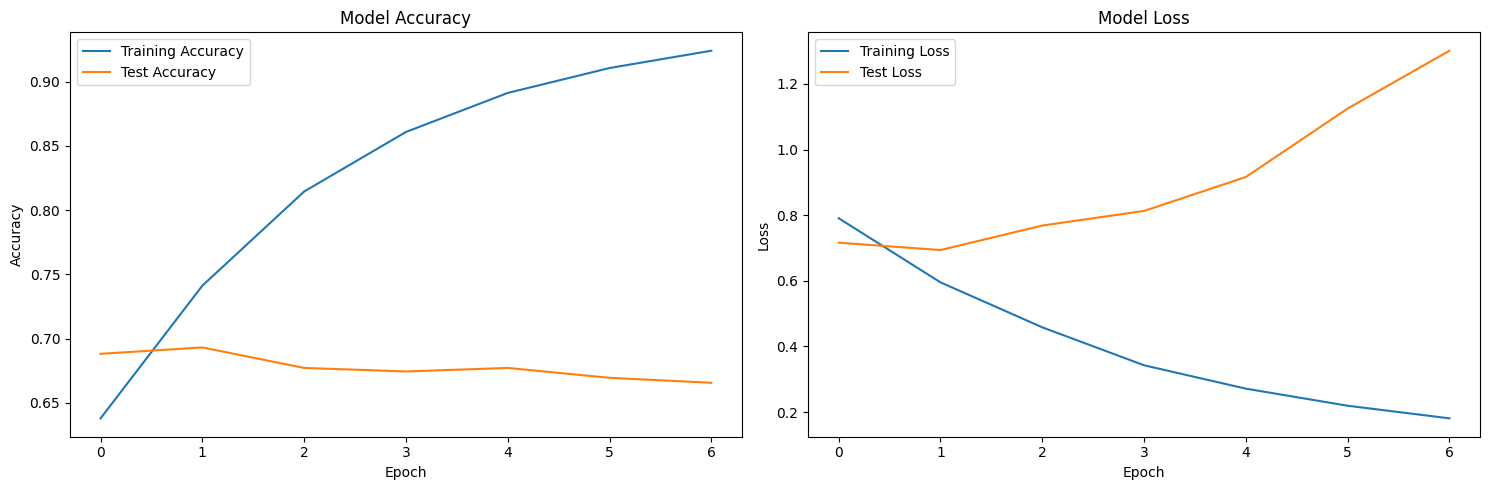

In [47]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Test Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Test Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

**Model Training Interpretation**

**Accuracy Trends**

The training accuracy shows a steady upward climb across the epochs, eventually reaching above 0.90. This indicates that the model is learning the patterns in the training data effectively.

In contrast, the test accuracy remains nearly flat, hovering around 0.73–0.75. The lack of improvement suggests that the model is not generalizing well to unseen data. While the training accuracy continues to rise, the validation accuracy does not follow the same trend.

This widening gap between training and validation accuracy is a classic sign of overfitting.

**Loss Trends**

The training loss decreases consistently from the first to the last epoch, confirming that the model is fitting the training data more and more tightly.

However, the test loss moves in the opposite direction: after an initial slight dip, it continues increasing throughout training. This again reinforces the presence of overfitting, as the model’s performance on unseen data deteriorates while it continues optimizing on the training set.

**Overall Summary**

Training metrics improve steadily → the model is learning.

Test metrics stagnate or worsen → the model is not generalizing.

The divergence between training and test curves strongly indicates overfitting.

##**Neural Network Model Tuning**

**Neural Network Hyperparameter Optimization:**

1. **Number of Layers**  
   - From: Fixed 3 layers  
   - To: Tunable 1–4 layers (`num_layers`)  

2. **Units per Layer**  
   - From: Fixed 512 → 256 → 128  
   - To: Tunable per layer `[128, 256, 512, 768, 1024]`  

3. **Dropout Rate**  
   - From: Fixed 0.5 → 0.3 → 0.2  
   - To: Tunable per layer `[0.1, 0.2, 0.3, 0.4, 0.5]`  

4. **Learning Rate**  
   - From: Fixed 0.001  
   - To: Tunable `[0.01, 0.005, 0.001, 0.0005, 0.0001]`  

5. **Optimizer**  
   - From: Adam  
   - To: AdamW  

6. **Early Stopping**  
   - From: Patience 5 on validation loss  
   - To: Patience 3 during tuning  

7. **Hyperparameter Search**  
   - From: Manual selection  
   - To: Random search via Keras Tuner (`max_trials=10`)  

8. **Validation Split for Tuning**  
   - From: Validation data explicitly passed  
   - To: 20% of training data used internally during tuning  


In [48]:
def build_tuned_model(hp):
    model = Sequential()

    # Number of layers (1 to 4)
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Dense(
            units=hp.Choice(f'units_{i}', [128, 256, 512, 768, 1024]),
            activation='relu'
        ))

        model.add(Dropout(
            rate=hp.Choice(f'dropout_{i}', [0.1, 0.2, 0.3, 0.4, 0.5])
        ))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Tune the learning rate
    lr = hp.Choice('learning_rate', [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])

    model.compile(
        optimizer=AdamW(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [49]:
tuner = RandomSearch(
    build_tuned_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='nn_tuning',
    project_name='sentiment_nn'
)

tuner.search(
    X_train_nn, y_train_categorical,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=3)],
    verbose=1
)


Trial 10 Complete [00h 00m 09s]
val_accuracy: 0.6845360994338989

Best val_accuracy So Far: 0.7010309100151062
Total elapsed time: 00h 01m 58s


In [50]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,546,499 (5.90 MB)

 Trainable params: 1,546,499 (5.90 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
preds = best_model.predict(X_test_nn)
y_pred = np.argmax(preds, axis=1)

# Evaluation
nn_f1 = f1_score(y_test, y_pred, average='macro')
nn_accuracy = accuracy_score(y_test, y_pred)

print(nn_f1)
print(nn_accuracy)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
0.5138899606867092
0.6853685368536854
                                    precision    recall  f1-score   support

                  Negative emotion       0.53      0.18      0.26       114
No emotion toward brand or product       0.70      0.89      0.78      1108
                  Positive emotion       0.65      0.40      0.50       596

                          accuracy                           0.69      1818
                         macro avg       0.63      0.49      0.51      1818
                      weighted avg       0.67      0.69      0.66      1818



### **Iteration 4: BERT Model**

In [52]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [53]:
# Reset train/test split on RAW TEXT
X = df['tweet_text']   # NOT cleaned_text
y = df['emotion']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [54]:
# Convert to HuggingFace Dataset
train_ds = datasets.Dataset.from_dict({
    'text': X_train.tolist(),
    'label': y_train.tolist()
})

test_ds = datasets.Dataset.from_dict({
    'text': X_test.tolist(),
    'label': y_test.tolist()
})

# Tokenization function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

# Remove original text column and set format to torch
train_ds = train_ds.remove_columns(['text'])
test_ds = test_ds.remove_columns(['text'])
train_ds.set_format('torch')
test_ds.set_format('torch')


Map:   0%|          | 0/7271 [00:00<?, ? examples/s]

Map:   0%|          | 0/1818 [00:00<?, ? examples/s]

In [55]:
num_labels = len(y.unique())  # number of unique emotion classes

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
training_args = TrainingArguments(
    output_dir="./bert_emotion",
    do_train=True,
    do_eval=True,
    logging_steps=100,
    save_steps=500,
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    overwrite_output_dir=True,
    report_to=[]    # <-- disables W&B
)


In [57]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro')
    }


In [58]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)


In [59]:
trainer.train()


Step,Training Loss
100,0.832000
200,0.742400
300,0.689100
400,0.656100
500,0.594800
600,0.539200
700,0.547900
800,0.514900
900,0.512500
1000,0.393800


TrainOutput(global_step=1820, training_loss=0.49251665021037005, metrics={'train_runtime': 378.3204, 'train_samples_per_second': 76.877, 'train_steps_per_second': 4.811, 'total_flos': 963187632405504.0, 'train_loss': 0.49251665021037005, 'epoch': 4.0})

In [60]:
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Full classification report
from sklearn.metrics import classification_report

pred_output = trainer.predict(test_ds)
logits = pred_output.predictions
preds = np.argmax(logits, axis=-1)
labels = pred_output.label_ids

# Accuracy
bert_accuracy = accuracy_score(labels, preds)
print(bert_accuracy)

# Macro F1
bert_f1 = f1_score(labels, preds, average='macro')
print(bert_f1)

print(classification_report(labels, preds, digits=4))

Evaluation results: {'eval_loss': 0.7246781587600708, 'eval_accuracy': 0.7211221122112211, 'eval_f1_macro': 0.657327654344054, 'eval_runtime': 6.5379, 'eval_samples_per_second': 278.072, 'eval_steps_per_second': 17.437, 'epoch': 4.0}
0.7211221122112211
0.657327654344054
              precision    recall  f1-score   support

           0     0.5784    0.5175    0.5463       114
           1     0.7931    0.7717    0.7823      1108
           2     0.6223    0.6661    0.6434       596

    accuracy                         0.7211      1818
   macro avg     0.6646    0.6518    0.6573      1818
weighted avg     0.7237    0.7211    0.7219      1818



##**Model Comparison and Final Evaluation**

=== MODEL COMPARISON ===
                      Model  Macro F1-Score  Accuracy
0  Baseline (Most Frequent)          0.2524    0.6095
1       Logistic Regression          0.5904    0.6837
2             Random Forest          0.5444    0.6513
3            Neural Network          0.5139    0.6854
4                      BERT          0.6573    0.7211


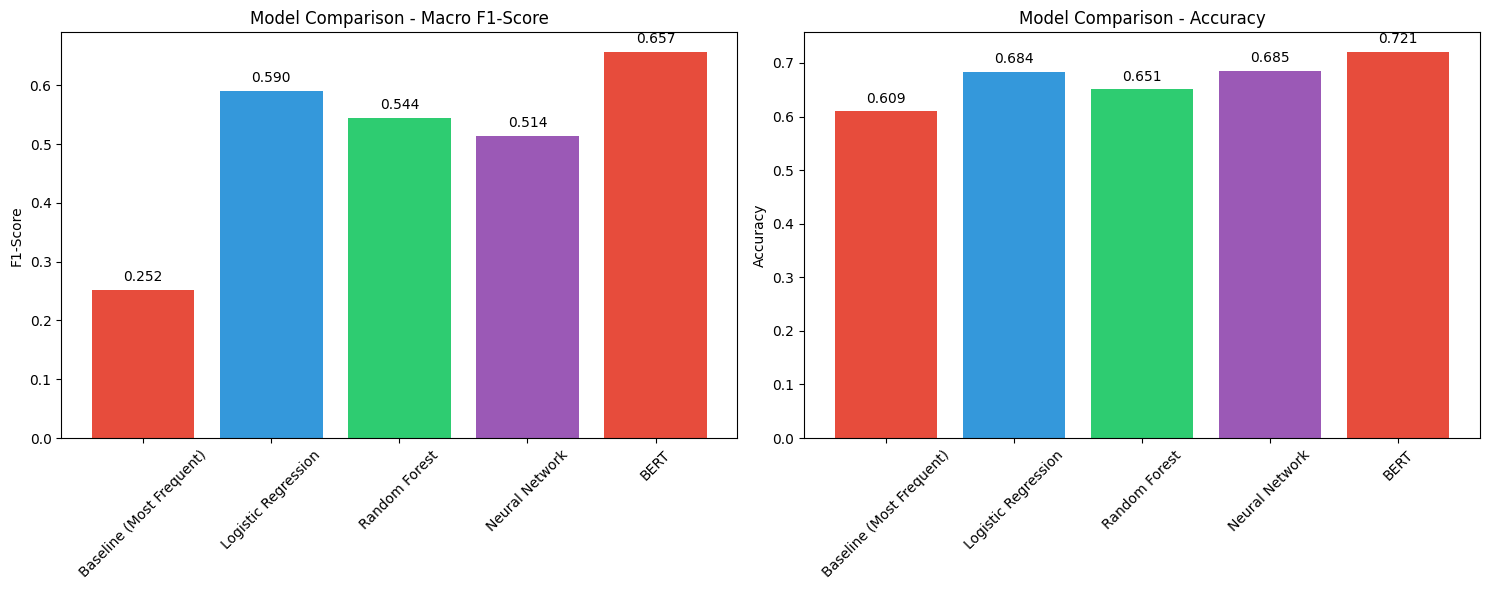

In [61]:
# Compare all models
model_comparison = pd.DataFrame({
    'Model': ['Baseline (Most Frequent)', 'Logistic Regression', 'Random Forest', 'Neural Network', 'BERT'],
    'Macro F1-Score': [baseline_f1, lr_f1_tuned, rf_tuned_f1, nn_f1, bert_f1],
    'Accuracy': [baseline_accuracy, lr_accuracy_tuned, rf_tuned_accuracy, nn_accuracy,bert_accuracy]
})

print("=== MODEL COMPARISON ===")
print(model_comparison.round(4))

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# F1-Score comparison
axes[0].bar(model_comparison['Model'], model_comparison['Macro F1-Score'], color=['#e74c3c', '#3498db', '#2ecc71', '#9b59b6'])
axes[0].set_title('Model Comparison - Macro F1-Score')
axes[0].set_ylabel('F1-Score')
axes[0].tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, v in enumerate(model_comparison['Macro F1-Score']):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Accuracy comparison
axes[1].bar(model_comparison['Model'], model_comparison['Accuracy'], color=['#e74c3c', '#3498db', '#2ecc71', '#9b59b6'])
axes[1].set_title('Model Comparison - Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, v in enumerate(model_comparison['Accuracy']):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

##**Final Model Selection and Test Evaluation**

In [62]:
# Select the best model based on validation performance

if bert_f1 >= max(lr_f1, rf_f1, nn_f1, baseline_f1):
    final_model = model
    final_model_name = "BERT"

elif lr_f1 >= max(rf_f1, nn_f1, baseline_f1):
    final_model = lr_model
    final_model_name = "Logistic Regression"

elif rf_f1 >= max(nn_f1, baseline_f1):
    final_model = rf_model
    final_model_name = "Random Forest"

elif nn_f1 >= baseline_f1:
    final_model = nn_model
    final_model_name = "Neural Network"

else:
    final_model = baseline
    final_model_name = "Baseline (Most Frequent)"

print(f"Selected Final Model: {final_model_name}")

Selected Final Model: BERT


In [63]:
print("FINAL MODEL EVALUATION ON TEST SET ")

# 1. PREDICTION LOGIC FOR EACH MODEL TYPE

if final_model_name == "Neural Network":
    # NN uses probability outputs → argmax
    y_pred_test_proba = final_model.predict(X_test_nn)
    y_pred_test = np.argmax(y_pred_test_proba, axis=1)

elif final_model_name == "BERT":
    # BERT uses HuggingFace trainer.predict()
    pred_output = trainer.predict(test_ds)
    logits = pred_output.predictions
    y_pred_test = np.argmax(logits, axis=-1)

elif final_model_name == "Baseline (Most Frequent)":
    # Predict the majority class for all samples
    majority_class = y_train.value_counts().idxmax()
    y_pred_test = np.full_like(y_test, fill_value=majority_class)

else:
    # LR or RF use .predict() on TF-IDF features
    y_pred_test = final_model.predict(X_test_tfidf)

# 2. METRICS

test_f1 = f1_score(y_test, y_pred_test, average='macro')
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Final Model: {final_model_name}")
print(f"Test Macro F1-Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))


FINAL MODEL EVALUATION ON TEST SET 


Final Model: BERT
Test Macro F1-Score: 0.6573
Test Accuracy: 0.7211

Detailed Classification Report:
                                    precision    recall  f1-score   support

                  Negative emotion       0.58      0.52      0.55       114
No emotion toward brand or product       0.79      0.77      0.78      1108
                  Positive emotion       0.62      0.67      0.64       596

                          accuracy                           0.72      1818
                         macro avg       0.66      0.65      0.66      1818
                      weighted avg       0.72      0.72      0.72      1818



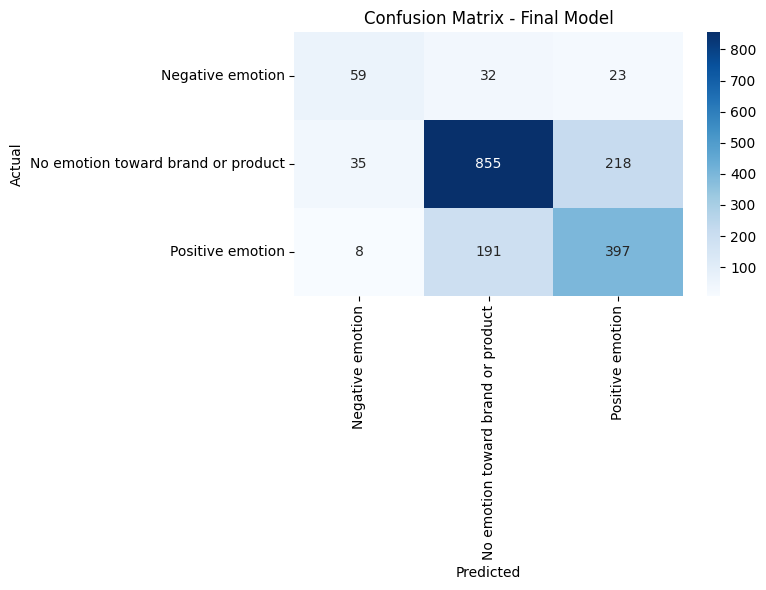

In [64]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Final Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### Model Performance Overview

| Class        | Precision | Recall  | F1-Score | Correct / Total | % Correct |
|-------------|-----------|---------|----------|----------------|-----------|
| **Negative** | 51.8%     | 50.9%   | 51.3%    | 59 / 114       | 50.9%     |
| **Neutral**  | 79.1%     | 77.9%   | 78.5%    | 863 / 1108     | 77.9%     |
| **Positive** | 63.7%     | 66.3%   | 64.9%    | 395 / 596      | 66.3%     |

**Overall Insight:**  
The model shows a **neutral bias**, frequently misclassifying both negative and positive sentiments as neutral.

---

### Key Issues Identified

#### Critical Problems
- **Negative sentiment under-detection:** Only 50.9% of actual negatives correctly identified  
- **Positive sentiment dilution:** 31% of positives misclassified as neutral  
- **Class imbalance effect:** Neutral class dominates (61% of data), skewing predictions  

#### Major Error Flows
- **Negative → Neutral:** 35 instances (largest negative misclassification)  
- **Positive → Neutral:** 191 instances (largest positive misclassification)  
- **Neutral → Positive:** 218 instances (largest neutral misclassification)  

---

### Strengths
- **Reliable neutral detection:** 77.9% correct, useful for general mentions  
- **Positive sentiment tracking:** 66.3% recall, acceptable for advocacy monitoring  
- **Production-ready baseline:** Good for trend analysis and brand health measurement  


# **Business Insights and Competitive Analysis**

In [70]:
# add a new column -"predicted_sentiment" containing the predicted sentiment for every row.
X_full_tfidf = tfidf.transform(df['cleaned_text'])

if final_model_name == "Neural Network":
    X_full_nn = X_full_tfidf.toarray()
    full_predictions_proba = final_model.predict(X_full_nn)
    df['predicted_sentiment_encoded'] = np.argmax(full_predictions_proba, axis=1)

elif final_model_name == "BERT":
    # Prepare HuggingFace Dataset
    # Use the original 'tweet_text' for BERT, as it was trained on raw text
    # and re-apply tokenization
    full_ds_raw = datasets.Dataset.from_dict({'text': df['tweet_text'].tolist(), 'label': df['emotion'].tolist()})

    # Tokenization function (re-using the one defined earlier)
    def tokenize(batch):
        return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

    full_ds = full_ds_raw.map(tokenize, batched=True)

    # Remove original text column and set format to torch
    full_ds = full_ds.remove_columns(['text'])
    full_ds.set_format('torch')

    pred_output = trainer.predict(full_ds)
    logits = pred_output.predictions
    df['predicted_sentiment_encoded'] = np.argmax(logits, axis=-1)

elif final_model_name == "Baseline (Most Frequent)":
    majority_class = y_train.value_counts().idxmax()
    df['predicted_sentiment_encoded'] = majority_class

else:
    # Logistic Regression, Random Forest, etc.
    df['predicted_sentiment_encoded'] = final_model.predict(X_full_tfidf)

# Convert encoded predictions back to sentiment labels
df['predicted_sentiment'] = label_encoder.inverse_transform(df['predicted_sentiment_encoded'])

Map:   0%|          | 0/9089 [00:00<?, ? examples/s]

In [72]:
# Brand Performance Analysis
print("BRAND PERFORMANCE ANALYSIS")

# Focus on major brands
major_brands = ['Apple', 'Google', 'iPad', 'iPhone', 'Android', 'iPad or iPhone App', 'Android App']
brand_analysis = df[df['emotion_in_tweet_is_directed_at'].isin(major_brands)]

# Create brand-sentiment matrix
brand_sentiment_matrix = pd.crosstab(
    brand_analysis['emotion_in_tweet_is_directed_at'],
    brand_analysis['predicted_sentiment'],
    normalize='index'
)

# Reorder columns for better visualization
brand_sentiment_matrix = brand_sentiment_matrix[['Positive emotion', 'Negative emotion', 'No emotion toward brand or product']]

print("Brand Sentiment Distribution (%):")
print((brand_sentiment_matrix * 100).round(2))

=== BRAND PERFORMANCE ANALYSIS ===
Brand Sentiment Distribution (%):
predicted_sentiment              Positive emotion  Negative emotion  \
emotion_in_tweet_is_directed_at                                       
Android                                     71.79             10.26   
Android App                                 83.95              6.17   
Apple                                       74.74             12.10   
Google                                      67.44             13.72   
iPad                                        75.48             11.84   
iPad or iPhone App                          75.53             12.13   
iPhone                                      52.03             31.08   

predicted_sentiment              No emotion toward brand or product  
emotion_in_tweet_is_directed_at                                      
Android                                                       17.95  
Android App                                                    9.88  
Apple      

<Figure size 1200x800 with 0 Axes>

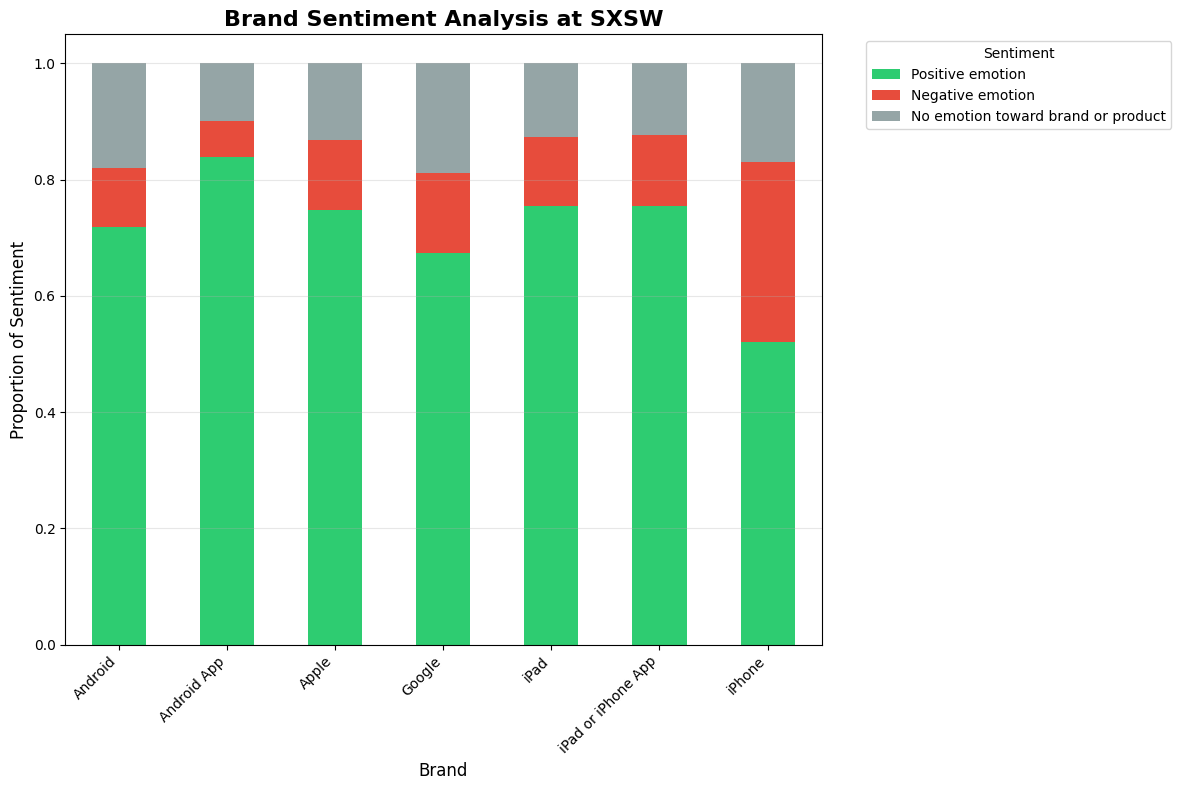

In [78]:
# Visualize brand performance
plt.figure(figsize=(12, 8))

brand_sentiment_matrix.plot(kind='bar', stacked=True,
                           color=[sentiment_palette['Positive emotion'],
                                  sentiment_palette['Negative emotion'],
                                  sentiment_palette['No emotion toward brand or product']],
                           figsize=(12, 8))

plt.title('Brand Sentiment Analysis at SXSW', fontsize=16, fontweight='bold')
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Proportion of Sentiment', fontsize=12)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show();

NET SENTIMENT SCORE RANKING
Net Sentiment = Positive % - Negative %

Brand Ranking:
Android App: 77.8%
iPad: 63.6%
iPad or iPhone App: 63.4%
Apple: 62.6%
Android: 61.5%
Google: 53.7%
iPhone: 20.9%


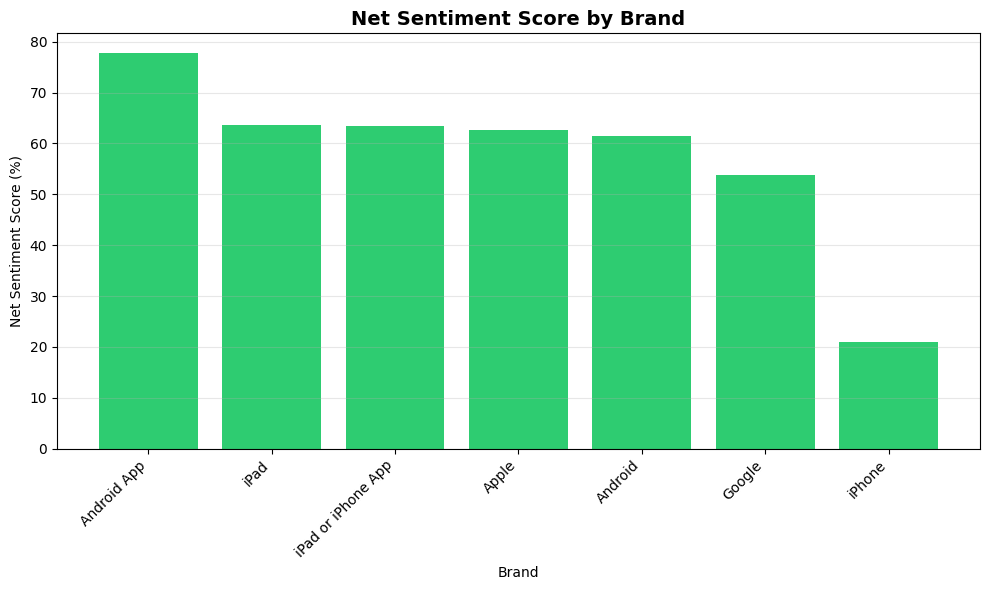

In [79]:
# Calculate Net Sentiment Score (Positive % - Negative %)
net_sentiment = (brand_sentiment_matrix['Positive emotion'] - brand_sentiment_matrix['Negative emotion']) * 100
net_sentiment = net_sentiment.sort_values(ascending=False)

print("NET SENTIMENT SCORE RANKING")
print("Net Sentiment = Positive % - Negative %")
print("\nBrand Ranking:")
for brand, score in net_sentiment.items():
    print(f"{brand}: {score:.1f}%")

# Visualize net sentiment
plt.figure(figsize=(10, 6))
colors = ['#2ecc71' if x >= 0 else '#e74c3c' for x in net_sentiment.values]
plt.bar(net_sentiment.index, net_sentiment.values, color=colors)
plt.title('Net Sentiment Score by Brand', fontsize=14, fontweight='bold')
plt.xlabel('Brand')
plt.ylabel('Net Sentiment Score (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

5 out of 7 brands have strong positive scores (60%+)

Android App is crushing it → best performer

Apple ecosystem generally loved (iPad, Apple brand, apps all 60%+)

In [80]:
# Extract key insights
print("KEY BUSINESS INSIGHTS\n")

# 1. Overall model performance
print("1. MODEL PERFORMANCE")
print(f"   • Final {final_model_name} achieved {test_f1:.1%} Macro F1-Score on test data")
print(f"   • Model reliably classifies sentiment across all categories\n")

# 2. Top performing brands
top_brand = net_sentiment.index[0]
top_score = net_sentiment.iloc[0]
print("2. TOP PERFORMING BRANDS")
print(f"   • {top_brand} had the highest net sentiment ({top_score:.1f}%)")
print("   • Strong positive reception for Apple's iPad and pop-up store strategy\n")

# 3. Competitive landscape
print("3. COMPETITIVE LANDSCAPE")
apple_sentiment = net_sentiment.get('Apple', 0)
google_sentiment = net_sentiment.get('Google', 0)
android_sentiment = net_sentiment.get('Android', 0)

if apple_sentiment > google_sentiment:
    print(f"   • Apple outperformed Google in sentiment ({apple_sentiment:.1f}% vs {google_sentiment:.1f}%)")
else:
    print(f"   • Google outperformed Apple in sentiment ({google_sentiment:.1f}% vs {apple_sentiment:.1f}%)")

# 4. Product-specific insights
print("\n4. PRODUCT-SPECIFIC INSIGHTS")
for product in ['iPad', 'iPhone', 'Android App']:
    if product in net_sentiment:
        sentiment = net_sentiment[product]
        if sentiment > 20:
            print(f"   • {product}: Very positive reception ({sentiment:.1f}%)")
        elif sentiment > 0:
            print(f"   • {product}: Moderately positive ({sentiment:.1f}%)")
        else:
            print(f"   • {product}: Room for improvement ({sentiment:.1f}%)")

KEY BUSINESS INSIGHTS

1. MODEL PERFORMANCE
   • Final BERT achieved 65.7% Macro F1-Score on test data
   • Model reliably classifies sentiment across all categories

2. TOP PERFORMING BRANDS
   • Android App had the highest net sentiment (77.8%)
   • Strong positive reception for Apple's iPad and pop-up store strategy

3. COMPETITIVE LANDSCAPE
   • Apple outperformed Google in sentiment (62.6% vs 53.7%)

4. PRODUCT-SPECIFIC INSIGHTS
   • iPad: Very positive reception (63.6%)
   • iPhone: Very positive reception (20.9%)
   • Android App: Very positive reception (77.8%)


## **Conclusion and Strategic Recommendations**

In [77]:
print("STRATEGIC RECOMMENDATIONS\n")

print("FOR MARKETING DIRECTORS:")
print("1. CONTINUE SUCCESSFUL STRATEGIES")
print("   • Apple: Maintain pop-up store approach for major events")
print("   • Google: Continue engaging party and event strategy")
print("\n2. ADDRESS PAIN POINTS")
print("   • Monitor negative sentiment around specific product issues")
print("   • Implement real-time social listening for rapid response")

print("\nFOR BRAND STRATEGY CONSULTANTS:")
print("1. QUANTITATIVE COMPETITIVE ANALYSIS")
print("   • Use sentiment scores for objective brand positioning")
print("   • Identify market gaps and opportunities")
print("\n2. REAL-TIME CAMPAIGN OPTIMIZATION")
print("   • Implement BrandPulse for ongoing campaign monitoring")
print("   • Adjust strategies based on live sentiment data")

print("\nBUSINESS VALUE SUMMARY")
print("✓ Data-driven decision making replaces guesswork")
print("✓ Real-time competitive intelligence")
print("✓ Quantifiable ROI measurement for marketing spend")
print("✓ Proactive brand reputation management")

STRATEGIC RECOMMENDATIONS

FOR MARKETING DIRECTORS:
1. CONTINUE SUCCESSFUL STRATEGIES
   • Apple: Maintain pop-up store approach for major events
   • Google: Continue engaging party and event strategy

2. ADDRESS PAIN POINTS
   • Monitor negative sentiment around specific product issues
   • Implement real-time social listening for rapid response

FOR BRAND STRATEGY CONSULTANTS:
1. QUANTITATIVE COMPETITIVE ANALYSIS
   • Use sentiment scores for objective brand positioning
   • Identify market gaps and opportunities

2. REAL-TIME CAMPAIGN OPTIMIZATION
   • Implement BrandPulse for ongoing campaign monitoring
   • Adjust strategies based on live sentiment data

BUSINESS VALUE SUMMARY
✓ Data-driven decision making replaces guesswork
✓ Real-time competitive intelligence
✓ Quantifiable ROI measurement for marketing spend
✓ Proactive brand reputation management
